In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import kmapper as km
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
import warnings
warnings.filterwarnings("ignore")
import networkx as nx
from ripser import ripser
from persim import plot_diagrams
import sys


In [58]:
import sys
sys.path.append('/Users/jesus/AuToMATo')
from automato import Automato

# Cargar las bases de datos

In [2]:
tag2024 = pd.read_excel('TAGS/Consolidado Edenred 2024.xlsx', sheet_name='Detalle de Movimientos 2024')
tag2022 = pd.read_excel('TAGS/Edenred Consolidado 2022.xlsx', sheet_name='Detalle de Movimientos por Fact')
tag2023 = pd.read_excel('TAGS/Edenred Consolidado Diciembre 2023.xlsx', sheet_name='Detalle de Movimientos ')
tag2021 = pd.read_excel('TAGS/Edenred Fuel Consumption Consolidation 2021.xlsx', sheet_name='Detalle de Movimientos por Fact')

Concatenar los cuatro años de datos

In [3]:
tag = pd.concat([tag2021, tag2022, tag2023, tag2024], ignore_index=True)

Checar las columnas consistentes en todos los datasets

In [4]:
# check Common columns across all years
common_columns = set(tag2021.columns).intersection(tag2022.columns).intersection(tag2023.columns).intersection(tag2024.columns)
print(f'Columnas comunes: {common_columns}')
len(common_columns)
tag = tag[list(common_columns)]

Columnas comunes: {'Observación', 'Fecha Transacción', 'Factura', 'Cantidad Mercancía', 'Arboles', 'Cliente', 'Rendimiento Real', 'Division', 'RFC', 'Id Mercancía', 'Id Grupo Región', 'No Estación Pemex', 'Km Transacción', 'Serie', 'Importe Transacción', 'Folio', 'Km Ant Transacción', 'BL', 'Placa', 'IVA', 'IVA %', 'Subtotal', 'Rendimiento', 'Número de Control', 'Id Región', 'Identificador Vehículo', 'Recorrido', 'IEPS', 'Comision', 'Num Serie', 'TON C02', 'Respuesta', 'Mercancía', 'Precio Unitario', 'Hora Transacción', 'Razón Social Afiliado', 'KG C02', 'Importe Neto', 'Month', 'No Comprobante', 'Num Tarjeta', 'Id Conductor', 'Conductor', 'Vehículo'}


In [5]:
# Tamaño del dataset
print(f'Tamaño del dataset: {tag.shape[0]} filas y {tag.shape[1]} columnas')

Tamaño del dataset: 48769 filas y 44 columnas


Corregir inconsistencias y errores en la base de datos

In [6]:
# Corregir los valores que no están en el formato abreviado de mes
# Crear un diccionario para mapear los nombres de meses en diferentes formatos al formato abreviado en inglés
month_mapping = {
    'ene.': 'Jan', 'feb.': 'Feb', 'mar.': 'Mar', 'abr.': 'Apr', 'may.': 'May', 'jun.': 'Jun',
    'jul.': 'Jul', 'ago.': 'Aug', 'sep.': 'Sep', 'oct.': 'Oct', 'nov.': 'Nov', 'dic.': 'Dec', 'Abr': 'Apr',
    'Jan': 'Jan', 'Feb': 'Feb', 'Mar': 'Mar', 'Apr': 'Apr', 'May': 'May', 'Jun': 'Jun',
    'Jul': 'Jul', 'Aug': 'Aug', 'Sep': 'Sep', 'Oct': 'Oct', 'Nov': 'Nov', 'Dec': 'Dec'
}

# Corregir los valores de la columna 'Month' utilizando el mapeo
tag['Month'] = tag['Month'].apply(lambda x: month_mapping.get(x, pd.to_datetime(x, errors='coerce').strftime('%b') if pd.notnull(pd.to_datetime(x, errors='coerce')) else None))
tag['Month'] = tag['Month'].apply(lambda x: month_mapping.get(x, pd.to_datetime(x, errors='coerce').strftime('%b') if pd.notnull(pd.to_datetime(x, errors='coerce')) else None))

In [7]:
tag['Fecha Transacción'] = pd.to_datetime(tag['Fecha Transacción'], format='%d/%m/%Y', errors='coerce')
# Convertir la columna 'Hora Transacción' al formato datetime.time
tag['Hora Transacción'] = pd.to_datetime(tag['Hora Transacción'], format='%H:%M:%S', errors='coerce').dt.time

# Variables a analizar

El analisis correspondiente a por que se eligieron estas columnas estan detalladas en la etapa 2

In [8]:
# Definir las columnas que se desean conservar
columnsToKeep = [
       'Month', 'Id Región',
       'Division', 'BL', 'Identificador Vehículo', 'Vehículo', 'Placa', 
       'Num Tarjeta', 'Num Serie', 'Fecha Transacción', 'Hora Transacción', 
       'Id Mercancía', 'Mercancía', 'Km Ant Transacción', 
       'Km Transacción', 'Recorrido',
       'Importe Transacción', 'Cantidad Mercancía', 
       'KG C02', 'Arboles', 'Precio Unitario', 'Rendimiento', 
       'Rendimiento Real', 
       # 'Id Conductor', 'Observación', 
       'Respuesta']

In [9]:
cuantitativas = ['Km Ant Transacción',
                'Km Transacción',
                'Recorrido',
                'Importe Transacción',
                'Cantidad Mercancía',
                'KG C02',
                'Arboles',
                'Precio Unitario',
                'Rendimiento',
                'Rendimiento Real']
cualitativas = ['Month',
                'Id Región',
                'Division',
                'BL',
                'Identificador Vehículo',
                'Vehículo',
                'Placa',
                'Num Tarjeta',
                'Num Serie',
                'Fecha Transacción',
                'Hora Transacción',
                'Id Mercancía',
                'Mercancía',
                # 'Id Conductor',
                # 'Observación',
                'Respuesta']

In [10]:
tag = tag[columnsToKeep]

# Limpieza de datos

In [11]:
tag.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48769 entries, 0 to 48768
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Month                   48769 non-null  object        
 1   Id Región               48764 non-null  object        
 2   Division                48769 non-null  object        
 3   BL                      48769 non-null  object        
 4   Identificador Vehículo  48769 non-null  object        
 5   Vehículo                48769 non-null  object        
 6   Placa                   48769 non-null  object        
 7   Num Tarjeta             48769 non-null  int64         
 8   Num Serie               48769 non-null  object        
 9   Fecha Transacción       48392 non-null  datetime64[ns]
 10  Hora Transacción        48355 non-null  object        
 11  Id Mercancía            48769 non-null  int64         
 12  Mercancía               48769 non-null  object

Nota: al quitar los nulos se pierden muchos datos (casi 10000 filas), para futuras pruebas, podemos quitar las variables cualitativas 'Id Conductor' y 'Observacion', que son las que tienen mas valores nulos, a ver si asi perdemos menos cantidad de datos

In [12]:
# Quitar valores nulos
tag = tag.dropna()

In [13]:
tag.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47337 entries, 7 to 48267
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Month                   47337 non-null  object        
 1   Id Región               47337 non-null  object        
 2   Division                47337 non-null  object        
 3   BL                      47337 non-null  object        
 4   Identificador Vehículo  47337 non-null  object        
 5   Vehículo                47337 non-null  object        
 6   Placa                   47337 non-null  object        
 7   Num Tarjeta             47337 non-null  int64         
 8   Num Serie               47337 non-null  object        
 9   Fecha Transacción       47337 non-null  datetime64[ns]
 10  Hora Transacción        47337 non-null  object        
 11  Id Mercancía            47337 non-null  int64         
 12  Mercancía               47337 non-null  object     

En el caso de las variables cuantitativas, revisar que los datos tengan sentido y que esten limpios y de buena calidad, observamos que:

- 'Recorrido' tiene valores negativos (imposible)
- 'Rendimiento real' tiene valores negativos (imposible)

In [14]:
tag[cuantitativas].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Km Ant Transacción,47337.0,142615.148974,453746.886501,0.000000e+00,40440.00000,86692.000000,135179.000000,9.850034e+06
Km Transacción,47337.0,145135.316898,464226.507596,0.000000e+00,41035.00000,87132.000000,135833.000000,9.850034e+06
Recorrido,47337.0,2520.167924,193656.085488,-9.750948e+06,156.00000,284.000000,445.000000,9.751982e+06
Importe Transacción,47337.0,2032.563575,2411.693766,2.319000e+01,994.50000,1399.900000,1834.520000,2.434409e+04
Cantidad Mercancía,47337.0,91.466853,102.102987,1.000000e+00,46.58151,65.373673,83.601739,1.000000e+03
KG C02,47337.0,219.905217,246.793481,2.421000e+00,111.36600,157.389210,201.006531,2.421000e+03
Arboles,47337.0,14.660348,16.452899,1.614000e-01,7.42440,10.492614,13.400435,1.614000e+02
Precio Unitario,47337.0,21.814363,8.166429,2.005176e+00,20.19000,21.831631,22.804784,1.111575e+03
Rendimiento,47337.0,12.277290,3.164694,1.000000e-02,10.00000,14.000000,14.000000,2.434000e+01
Rendimiento Real,47337.0,-62.098012,17766.115928,-3.666055e+06,2.31000,4.900000,8.040000,5.414736e+05


In [15]:
# Revisar cuantos valores de 'Recorrido' son negativos
recorrido_negativos = tag[tag['Recorrido'] < 0]
print(f'Cantidad de recorridos negativos: {recorrido_negativos.shape[0]}')

Cantidad de recorridos negativos: 1720


In [16]:
# Revisar cuantos valores de 'Rendimiento Real' son negativos
rendimiento_real_negativos = tag[tag['Rendimiento Real'] < 0]
print(f'Cantidad de rendimientos reales negativos: {rendimiento_real_negativos.shape[0]}')

Cantidad de rendimientos reales negativos: 1700


In [17]:
# Drop the negative values
tag = tag[tag['Recorrido'] >= 0]
tag = tag[tag['Rendimiento Real'] >= 0]

Implementar un metodo de deteccion de outliers (en mi caso el z-score) y revisar nuevamente nuestra base de datos

In [18]:
for column in cuantitativas:
    z_scores = stats.zscore(tag[column].dropna())
    outliers = tag[abs(z_scores) > 3]
    print(f'Cantidad de outliers en {column}: {outliers.shape[0]}')

Cantidad de outliers en Km Ant Transacción: 382
Cantidad de outliers en Km Transacción: 416
Cantidad de outliers en Recorrido: 241
Cantidad de outliers en Importe Transacción: 1352
Cantidad de outliers en Cantidad Mercancía: 1277
Cantidad de outliers en KG C02: 1291
Cantidad de outliers en Arboles: 1291
Cantidad de outliers en Precio Unitario: 84
Cantidad de outliers en Rendimiento: 334
Cantidad de outliers en Rendimiento Real: 176


In [19]:
for column in cuantitativas:
    z_scores = stats.zscore(tag[column].dropna())
    outliers = tag[abs(z_scores) > 3]
    # Drop the outliers
    tag = tag[abs(z_scores) <= 3]

In [20]:
tag[cuantitativas].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Km Ant Transacción,38812.0,93467.806323,74601.841099,0.000000,40094.500000,83628.500000,128465.500000,720260.000000
Km Transacción,38812.0,93854.621663,74618.007468,0.000000,40509.750000,83932.000000,128794.250000,720310.000000
Recorrido,38812.0,386.815341,876.011451,0.000000,177.000000,289.000000,425.000000,34445.000000
Importe Transacción,38812.0,1317.922577,518.500691,23.740000,942.532044,1307.792000,1641.985000,3761.901359
Cantidad Mercancía,38812.0,61.609144,23.043908,1.000000,44.747500,61.040000,78.384968,135.572799
KG C02,38812.0,148.628604,55.700159,2.421000,107.661870,147.245220,189.158782,328.221746
Arboles,38812.0,9.908574,3.713344,0.161400,7.177458,9.816348,12.610585,21.881450
Precio Unitario,38812.0,21.389053,1.805973,4.143953,19.990000,21.609991,22.510587,41.055408
Rendimiento,38812.0,12.183020,3.003923,3.000000,10.000000,14.000000,14.000000,21.650000
Rendimiento Real,38812.0,7.569871,14.747003,0.000000,3.160000,5.410000,8.130000,281.460000


<Figure size 2000x2000 with 0 Axes>

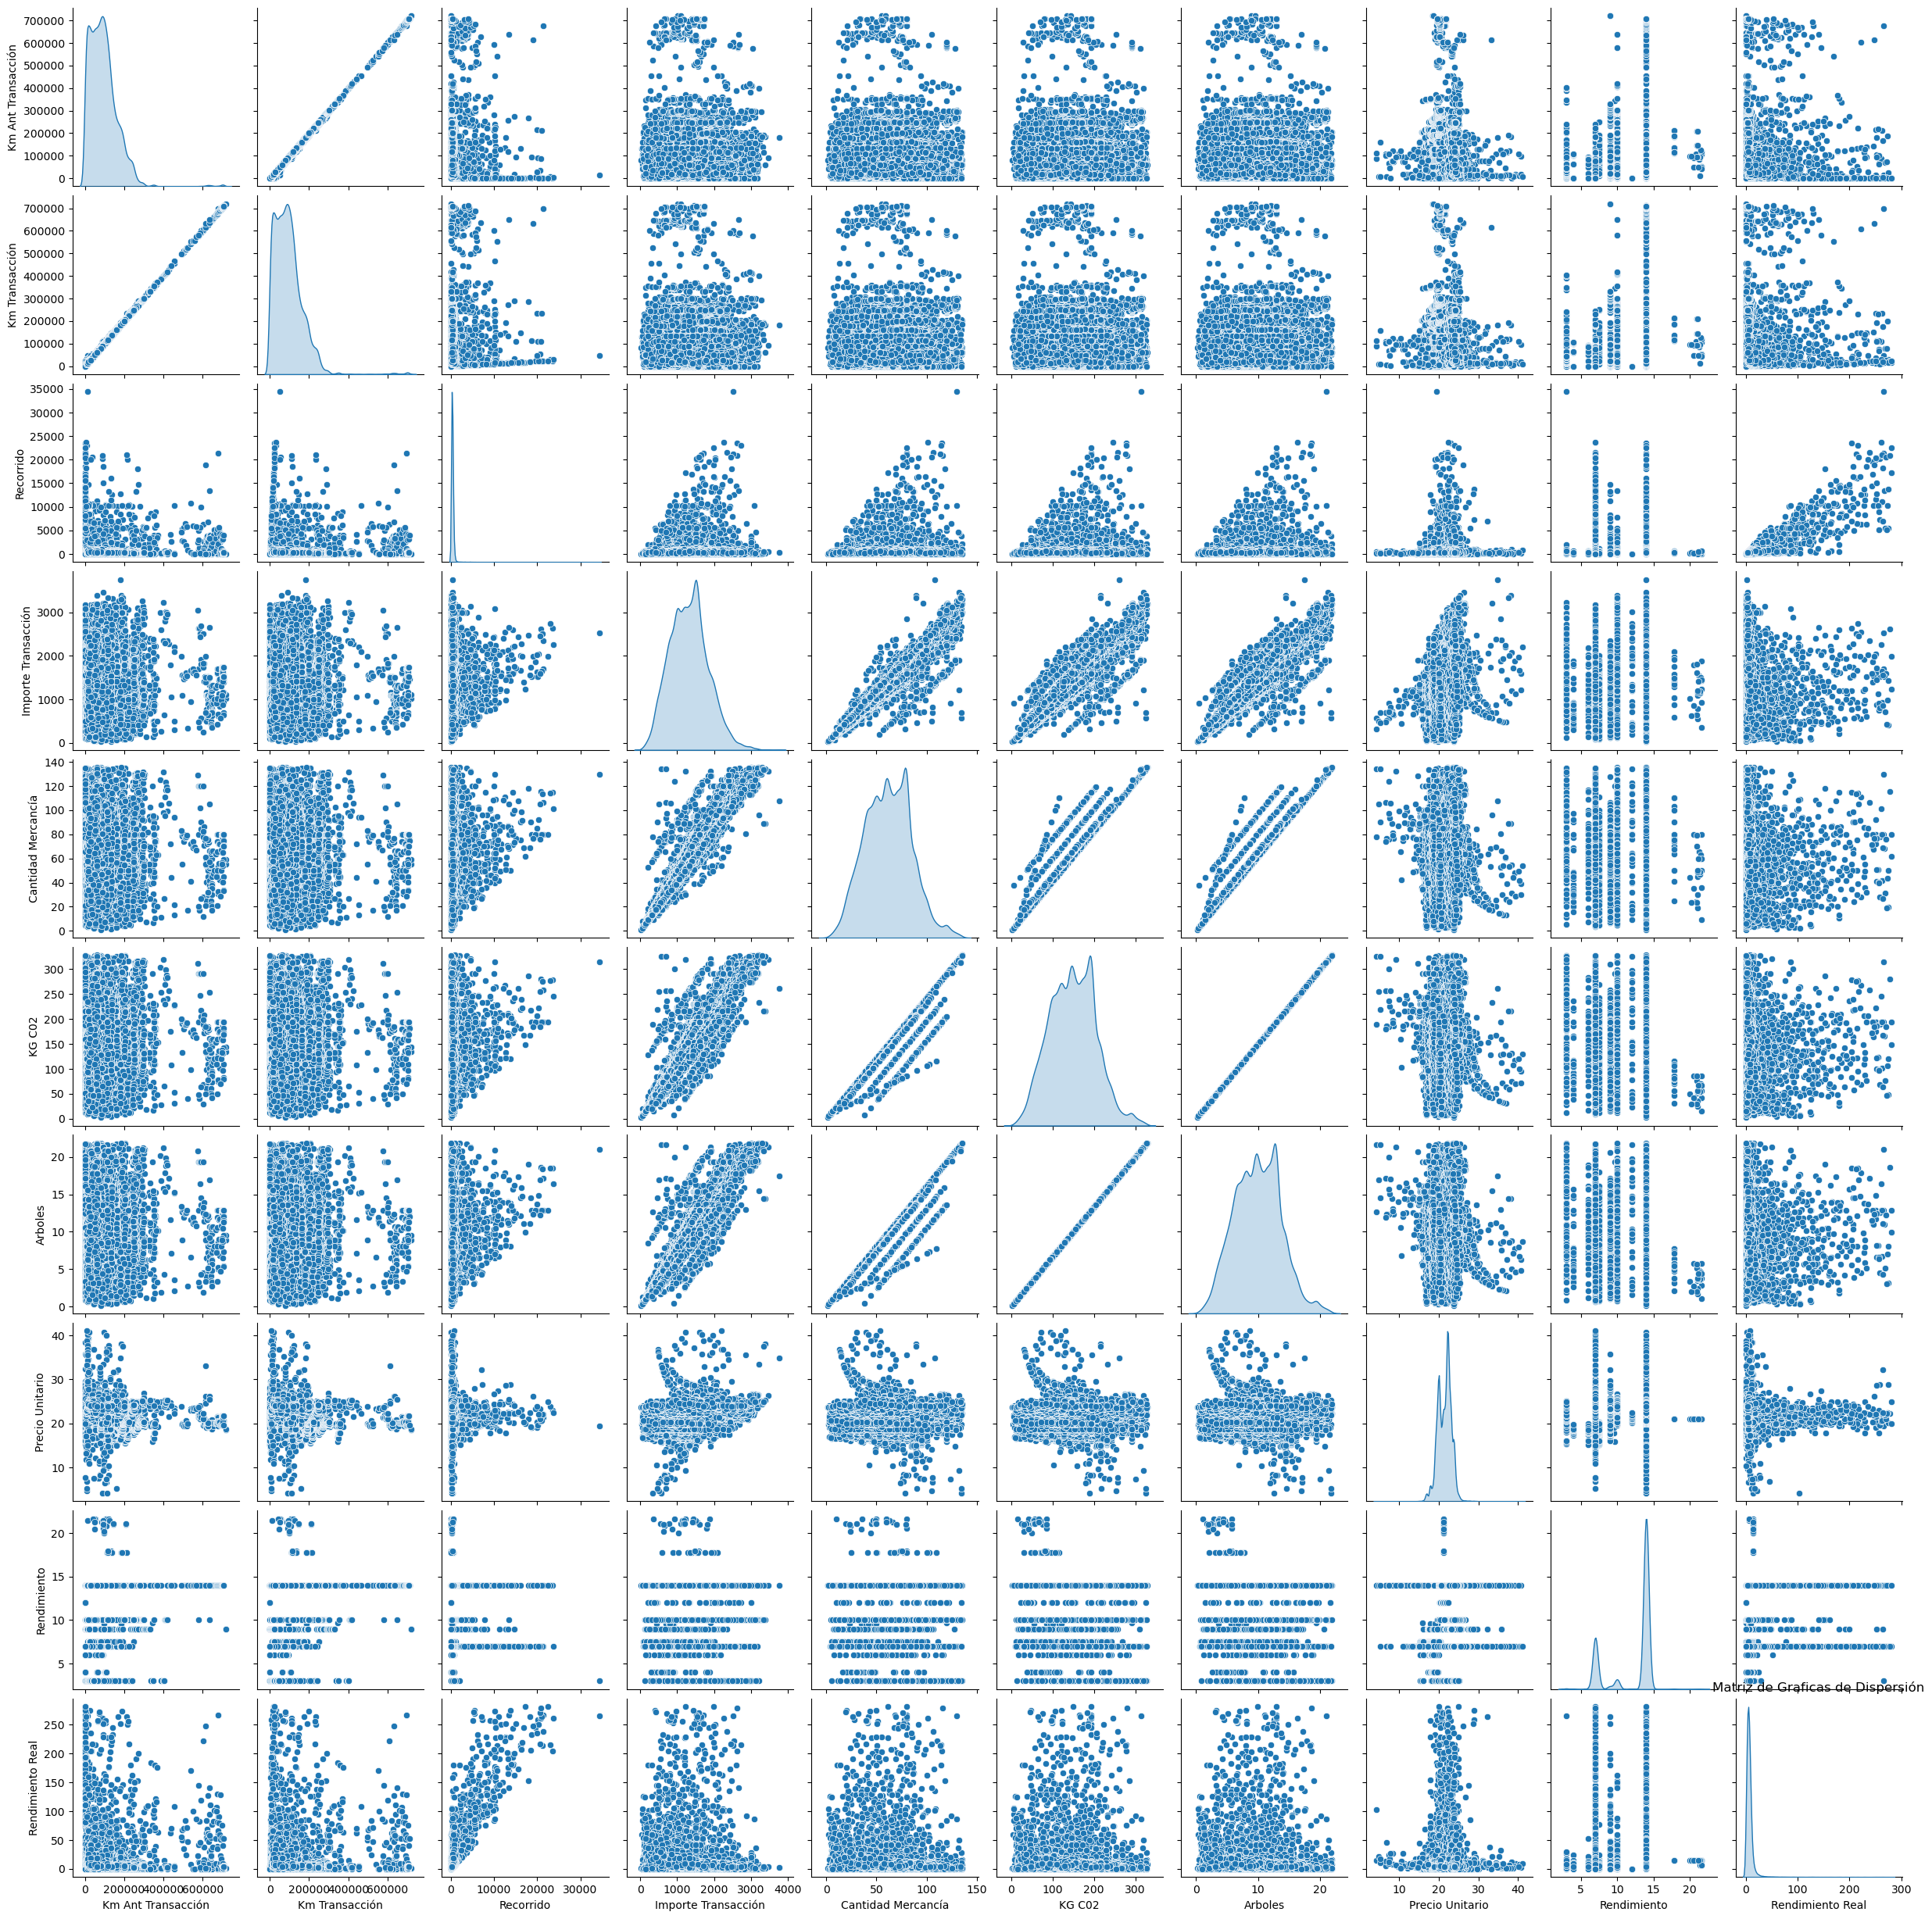

In [21]:
plt.figure(figsize=(20, 20))
sns.pairplot(tag[cuantitativas], diag_kind='kde')
plt.title('Matriz de Graficas de Dispersión')
plt.savefig('TAGS/Matriz de Graficas de Dispersión.png', dpi=300, bbox_inches='tight')
plt.show()

# Escalado de los datos

In [22]:
tag.reset_index(drop=True, inplace=True)
X = tag[cuantitativas].copy()
# Normalizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA

In [46]:
mapper = km.KeplerMapper(verbose=1)
lens = PCA(n_components=2).fit_transform(X_scaled) 

KeplerMapper(verbose=1)


Text(0, 0.5, 'PCA Component 2')

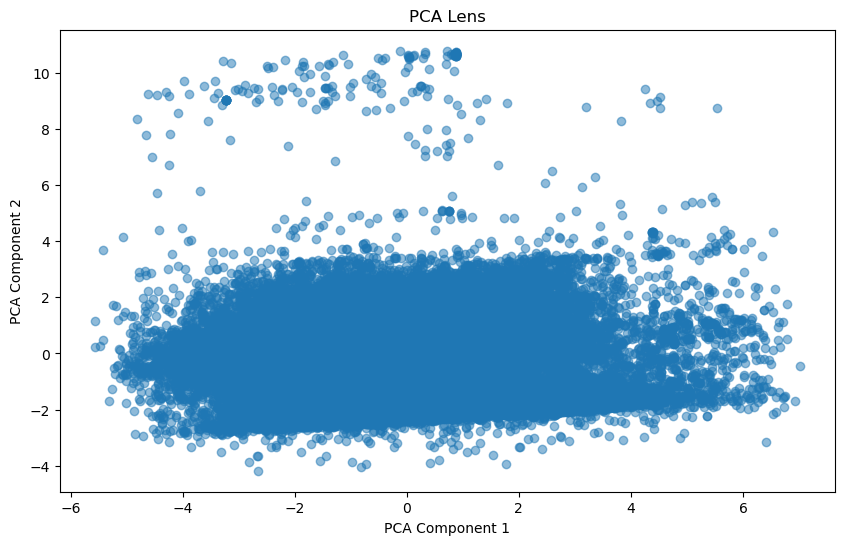

In [50]:
# Plot the PCA lens
plt.figure(figsize=(10, 6))
plt.scatter(lens[:, 0], lens[:, 1], alpha=0.5)
plt.title('PCA Lens')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

# Mapper

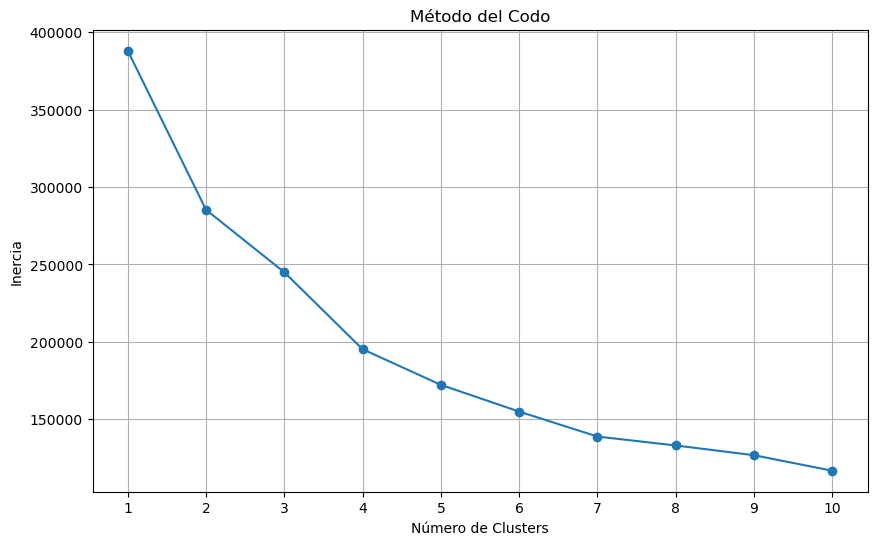

In [24]:
# Metodo del codo para determinar el número óptimo de clusters
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    
# Graficar el método del codo
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.xticks(range(1, 11))
plt.grid()
plt.show()

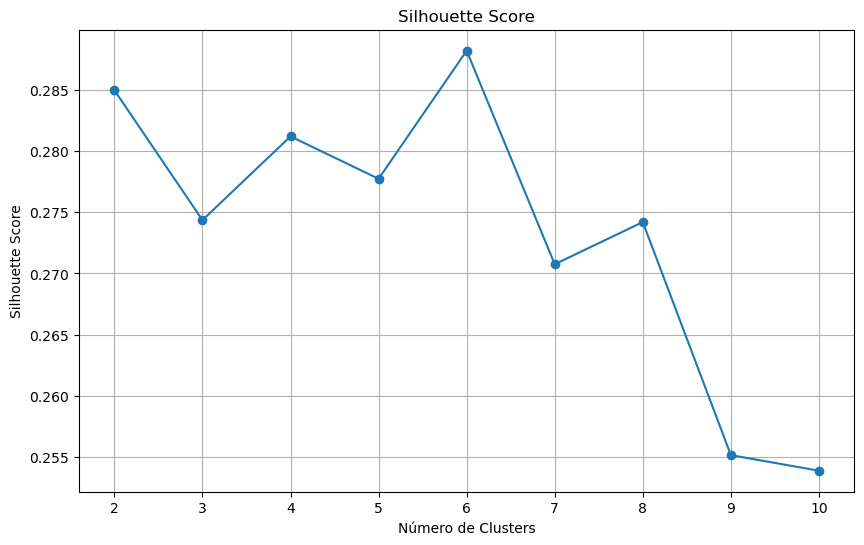

In [25]:
# Silhouette Score para determinar el número óptimo de clusters
from sklearn.metrics import silhouette_score
silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_scaled)
    score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(score)

# Graficar el Silhouette Score
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Número de Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(range(2, 11))
plt.grid()
plt.show()

In [47]:
graph = mapper.map(
    lens,  # datos de entrada
    X_scaled,  # datos originales
    clusterer=KMeans(n_clusters=6, random_state=12),  # algoritmo de agrupamiento
    cover=km.Cover(n_cubes=4, perc_overlap=0.09),  # cubos y superposición
)

# Visualizar el grafo
html_output = mapper.visualize(
    graph,
    title="Mapper Problema 3",
    X = X.values,
    X_names = X.columns.tolist(),
    custom_tooltips=(
        tag['Identificador Vehículo']
    ),
    color_values=tag[['KG C02', 'Arboles', 'Rendimiento', 'Rendimiento Real']],
    color_function_name=['KG C02', 'Arboles', 'Rendimiento', 'Rendimiento Real'],
    node_color_function=['mean', 'max', 'min'],
    nbins=10,
    include_searchbar=True,
    include_min_intersection_selector=True,
    path_html="TAGS.html",
    # color_values=skills['value_eur'],
    # color_function_name="Value in Euros",
)

Mapping on data shaped (38812, 10) using lens shaped (38812, 2)

Creating 16 hypercubes.

Created 175 edges and 96 nodes in 0:00:03.402248.
Wrote visualization to: TAGS.html


Utilizaremos "Identificador Vehiculo" como el id unico de los vehiculos, a pesar de haber varios tipos de identificadores, de los cuales tenemos poca informacion, el mas consistente es el antes ya mencionado

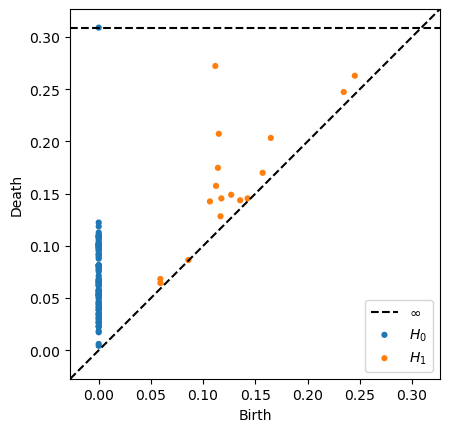

In [48]:
from ripser import ripser
from persim import plot_diagrams
import numpy as np

X = np.random.random((100, 2))  # nube de puntos

result = ripser(X)
plot_diagrams(result['dgms'], show=True)

In [59]:
from automato import Automato
from sklearn.datasets import make_blobs
X, y = make_blobs(centers=2, random_state=42)
aut = Automato(random_state=42).fit(X)

AssertionError: 